In [1]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv("../../data/release_train_patients.csv.txt")

In [3]:
pathologies_df = pd.read_json("../../data/release_conditions.json")
evidences_df = pd.read_json("../../data/release_evidences.json")

In [4]:
train_df.head()

,AGE,DIFFERENTIAL_DIAGNOSIS,SEX,PATHOLOGY,EVIDENCES,INITIAL_EVIDENCE
0,18,"[['Bronchitis', 0.19171203430383882], ['Pneumo...",M,URTI,"['E_48', 'E_50', 'E_53', 'E_54_@_V_161', 'E_54...",E_91
1,21,"[['HIV (initial infection)', 0.518950056440760...",M,HIV (initial infection),"['E_9', 'E_27', 'E_50', 'E_51', 'E_53', 'E_54_...",E_50
2,19,"[['Bronchitis', 0.11278064619119596], ['Pneumo...",F,Pneumonia,"['E_53', 'E_54_@_V_179', 'E_54_@_V_192', 'E_55...",E_77
3,34,"[['URTI', 0.23859396799565236], ['Cluster head...",F,URTI,"['E_48', 'E_53', 'E_54_@_V_183', 'E_55_@_V_89'...",E_53
4,36,"[['URTI', 0.23677812769175735], ['Influenza', ...",M,URTI,"['E_49', 'E_50', 'E_53', 'E_54_@_V_183', 'E_55...",E_201


# Extract meaningful dataframes/dictionaries from data

In [5]:
import ast

# Treat lists of diagnoses and evidences as lists, not strings
train_df['DIFFERENTIAL_DIAGNOSIS'] = train_df['DIFFERENTIAL_DIAGNOSIS'].apply(ast.literal_eval)
train_df['EVIDENCES'] = train_df['EVIDENCES'].apply(ast.literal_eval)

train_dds = train_df["DIFFERENTIAL_DIAGNOSIS"]
train_evs = train_df["EVIDENCES"]

all_paths = pathologies_df.keys()
all_evs_ids = evidences_df.keys()
all_evs_dic = evidences_df

In [6]:
pd.Series(list(all_paths)).sample(5)

29              Stable angina
36         Pulmonary embolism
28            Unstable angina
5     HIV (initial infection)
17        Atrial fibrillation
dtype: object

In [7]:
pd.Series(list(all_evs_ids)).sample(5)

21      E_51
3       E_57
145      E_2
64     E_212
63      E_39
dtype: object

## Create dictionaries of encoded medical questions and answers to medical questions

In [8]:
question_dict = {entry['code_question']: entry['question_en'] for key, entry in evidences_df.items() if 'code_question' in entry and 'question_en' in entry}
value_meaning_dict = {}
for key, entry in evidences_df.items():
    if 'value_meaning' in entry and entry['value_meaning']:
        value_meaning_dict.update({v_key: v_data['en'] for v_key, v_data in entry['value_meaning'].items()})

In [9]:
pd.Series(question_dict).sample(5)

E_181    Do you have nasal congestion or a clear runny ...
E_169       Is your nose or the back of your throat itchy?
E_16                                  Do you feel anxious?
E_176    Did you previously, or do you currently, have ...
E_65     Do you have difficulty swallowing, or have a f...
dtype: object

In [33]:
pd.Series(value_meaning_dict).sample(5)

V_22            anus
V_97      big toe(R)
V_197     epigastric
V_178     triceps(L)
V_29     lower chest
dtype: object

## Create dictionary of evidences (i.e questions + answers combined)

In [11]:
import json

def create_evidence_mapping_from_json(evidences_json):
    """
    Create a mapping of evidence encodings to human-readable question-answer pairs.
    """
    evidence_mapping = {}

    # Load the JSON file
    with open(evidences_json) as f:
        evidences_data = json.load(f)

    # Loop through each entry in the JSON file to build the dictionary
    for key, entry in evidences_data.items():
        if 'name' in entry and 'question_en' in entry:
            question_code = entry['name']
            question_text = entry['question_en']

            # If there are associated answers, combine the question with answers
            if 'value_meaning' in entry and entry['value_meaning']:
                for answer_code, answer_data in entry['value_meaning'].items():
                    answer_text = answer_data.get('en', '')
                    composite_key = f"{question_code}_@_{answer_code}"
                    # Combine question and answer
                    evidence_mapping[composite_key] = f"{question_text}: {answer_text}"
            elif 'possible-values' in entry and entry['possible-values']:
                for answer_code in entry['possible-values']:
                    composite_key = f"{question_code}_@_{answer_code}"
                    evidence_mapping[composite_key] = f"{question_text}: {answer_code}"
            else:
                # If it's a binary question without specific answer codes
                evidence_mapping[question_code] = question_text

    return evidence_mapping


In [12]:
# Assuming question_dict and answer_dict are already loaded as dictionaries
evidence_mapping = create_evidence_mapping_from_json("../../data/release_evidences.json")

In [13]:
print(evidence_mapping.get("E_58_@_8"))

How precisely is the pain located?: 8


In [14]:
print(len(evidence_mapping))

972


## Example question-answer dialogue

In [15]:
def convert_evidence_to_natural_language(evidence_list, evidence_mapping):
    """
    Convert a list of evidence encodings to their natural language equivalents.
    
    Parameters:
    - evidence_list: List of evidence encodings (e.g., ['E_54_@_V_154', 'E_66'])
    - evidence_mapping: Dictionary mapping encodings to human-readable text.
    
    Returns:
    - List of natural language representations of the evidences.
    """
    natural_language_list = []

    for evidence in evidence_list:
        # Get the natural language representation from the mapping
        if evidence in evidence_mapping:
            natural_language_list.append(evidence_mapping[evidence])
        else:
            natural_language_list.append(f"Unknown encoding: {evidence}")

    return natural_language_list

In [16]:
exs = train_evs[0:5]
for i in exs:
    natural_dialogue_list = convert_evidence_to_natural_language(i, evidence_mapping)
    print(natural_dialogue_list)        

['Do you live with 4 or more people?', 'Have you had significantly increased sweating?', 'Do you have pain somewhere, related to your reason for consulting?', 'Characterize your pain:: sensitive', 'Characterize your pain:: heavy', 'Do you feel pain somewhere?: forehead', 'Do you feel pain somewhere?: cheek(R)', 'Do you feel pain somewhere?: temple(L)', 'How intense is the pain?: 4', 'Does the pain radiate to another location?: nowhere', 'How precisely is the pain located?: 3', 'How fast did the pain appear?: 3', 'Do you have a cough that produces colored or more abundant sputum than usual?', 'Do you smoke cigarettes?', 'Do you have a fever (either felt or measured with a thermometer)?', 'Do you have a sore throat?', 'Do you have a cough?', 'Have you traveled out of the country in the last 4 weeks?: N', 'Are you exposed to secondhand cigarette smoke on a daily basis?']
['Do you have swollen or painful lymph nodes?', 'Have you ever had a sexually transmitted infection?', 'Have you had si

# Data Preprocessing for EDA

## Differential diagnoses
#### add probabilities of 0 to pathologies that don't appear in every example's DD

In [17]:
def fill_missing_pathologies(diagnoses, all_pathologies):
    # Create a dictionary of current pathologies and their probabilities
    diag_dict = {diag[0]: diag[1] for diag in diagnoses}

    # Fill missing pathologies with 0
    filled_diagnoses = [[pathology, diag_dict.get(pathology, 0)] for pathology in all_pathologies]

    return filled_diagnoses

In [18]:
ex = train_dds[0]
ex_out = fill_missing_pathologies(ex, list(all_paths))
print(ex_out)

[['Spontaneous pneumothorax', 0], ['Cluster headache', 0], ['Boerhaave', 0], ['Spontaneous rib fracture', 0], ['GERD', 0], ['HIV (initial infection)', 0.07333003867293564], ['Anemia', 0], ['Viral pharyngitis', 0], ['Inguinal hernia', 0], ['Myasthenia gravis', 0], ['Whooping cough', 0], ['Anaphylaxis', 0], ['Epiglottitis', 0], ['Guillain-Barré syndrome', 0], ['Acute laryngitis', 0], ['Croup', 0], ['PSVT', 0], ['Atrial fibrillation', 0], ['Bronchiectasis', 0.12429044460990353], ['Allergic sinusitis', 0], ['Chagas', 0.04984197229703562], ['Scombroid food poisoning', 0], ['Myocarditis', 0], ['Larygospasm', 0], ['Acute dystonic reactions', 0], ['Localized edema', 0], ['SLE', 0], ['Tuberculosis', 0.11367177304035844], ['Unstable angina', 0], ['Stable angina', 0], ['Ebola', 0], ['Acute otitis media', 0], ['Panic attack', 0], ['Bronchospasm / acute asthma exacerbation', 0], ['Bronchitis', 0.19171203430383882], ['Acute COPD exacerbation / infection', 0], ['Pulmonary embolism', 0], ['URTI', 0.16

In [19]:
dev_dds = train_dds[0:5]
dev_dds_full = dev_dds.apply(lambda x: fill_missing_pathologies(x, list(all_paths)))

In [20]:
print(train_dds[2])
print(dev_dds_full[2])

[['Bronchitis', 0.11278064619119596], ['Pneumonia', 0.10048134562119852], ['Unstable angina', 0.08462979865697953], ['Possible NSTEMI / STEMI', 0.08343170881871906], ['Bronchiectasis', 0.07764173703530038], ['Boerhaave', 0.07708363099826726], ['Spontaneous rib fracture', 0.07682349455456361], ['Pericarditis', 0.07504681799224715], ['URTI', 0.06705952510476514], ['Stable angina', 0.06667817325012103], ['GERD', 0.06455232704351052], ['Scombroid food poisoning', 0.058790058668404095], ['Chagas', 0.02923384001251551], ['Sarcoidosis', 0.016406922262218876], ['Panic attack', 0.009359973789993502]]
[['Spontaneous pneumothorax', 0], ['Cluster headache', 0], ['Boerhaave', 0.07708363099826726], ['Spontaneous rib fracture', 0.07682349455456361], ['GERD', 0.06455232704351052], ['HIV (initial infection)', 0], ['Anemia', 0], ['Viral pharyngitis', 0], ['Inguinal hernia', 0], ['Myasthenia gravis', 0], ['Whooping cough', 0], ['Anaphylaxis', 0], ['Epiglottitis', 0], ['Guillain-Barré syndrome', 0], ['Acu

In [21]:
dds_full = train_dds.apply(lambda x: fill_missing_pathologies(x, list(all_paths)))
train_df["DIFFERENTIAL_DIAGNOSIS_FULL"] = dds_full

## Find pathology predicted by the differential diagnosis
#### The differential diagnosis is generated differently than the rest of the variables, including pathology, in this dataset, hence the disease with the highest probability is not necessarily the same as the disease in the pathology field. Since differential diagnosis will likely be the outcome we analyze, we create an automatic_diagnosis_prediction field representing the disease of maximum probability for each patient's differential diagnosis.

In [22]:
# Function to extract the disease with the highest probability
def get_predicted_pathology(diagnoses):
    # Sort the list by probability (descending) and return the disease with the highest probability
    if diagnoses:
        return max(diagnoses, key=lambda x: x[1])[0]
    return None

In [23]:
ex_predicted = train_dds[0]
ex_predicted_out = get_predicted_pathology(ex_predicted)

In [24]:
print(ex_predicted)
print(ex_predicted_out)

[['Bronchitis', 0.19171203430383882], ['Pneumonia', 0.17579340398940366], ['URTI', 0.1607809719801254], ['Bronchiectasis', 0.12429044460990353], ['Tuberculosis', 0.11367177304035844], ['Influenza', 0.11057936110639896], ['HIV (initial infection)', 0.07333003867293564], ['Chagas', 0.04984197229703562]]
Bronchitis


In [25]:
dev_pathologies = train_dds[0:5]
dev_predicted_pathologies = dev_pathologies.apply(lambda x: get_predicted_pathology(x))

In [26]:
train_df["AUTOMATIC_DIAGNOSIS_PREDICTION"] = train_dds.apply(lambda x: get_predicted_pathology(x))

In [27]:
print(len(train_df["AUTOMATIC_DIAGNOSIS_PREDICTION"].unique()))
print(train_df["AUTOMATIC_DIAGNOSIS_PREDICTION"].unique())

48
['Bronchitis' 'HIV (initial infection)' 'URTI' 'Acute rhinosinusitis'
 'Anemia' 'PSVT' 'Allergic sinusitis' 'Croup' 'Cluster headache'
 'Anaphylaxis' 'Spontaneous pneumothorax' 'Acute pulmonary edema'
 'Myasthenia gravis' 'Panic attack' 'Scombroid food poisoning'
 'Epiglottitis' 'Pneumonia' 'Inguinal hernia' 'Boerhaave'
 'Pancreatic neoplasm' 'SLE' 'Acute laryngitis' 'Unstable angina'
 'Viral pharyngitis' 'Possible NSTEMI / STEMI' 'Localized edema'
 'Sarcoidosis' 'Spontaneous rib fracture'
 'Acute COPD exacerbation / infection' 'GERD'
 'Bronchospasm / acute asthma exacerbation' 'Guillain-Barré syndrome'
 'Pulmonary embolism' 'Pericarditis' 'Whooping cough'
 'Atrial fibrillation' 'Acute dystonic reactions' 'Pulmonary neoplasm'
 'Chagas' 'Influenza' 'Tuberculosis' 'Larygospasm' 'Acute otitis media'
 'Myocarditis' 'Chronic rhinosinusitis' 'Ebola' 'Bronchiectasis'
 'Bronchiolitis']


## Expand evidences to binary columns

In [39]:
def parse_evidences(evidences):
    parsed_evidences = {}

    for evidence in evidences:
        parsed_evidences[evidence] = 1

    return parsed_evidences

In [40]:
ex_parse = train_evs[2]
print(ex_parse)
ex_parse_out = parse_evidences(ex_parse)
print(ex_parse_out)

['E_53', 'E_54_@_V_179', 'E_54_@_V_192', 'E_55_@_V_29', 'E_55_@_V_55', 'E_55_@_V_56', 'E_55_@_V_170', 'E_55_@_V_171', 'E_56_@_5', 'E_57_@_V_123', 'E_58_@_2', 'E_59_@_6', 'E_77', 'E_78', 'E_79', 'E_94', 'E_106', 'E_118', 'E_123', 'E_124', 'E_129', 'E_130_@_V_156', 'E_131_@_V_12', 'E_132_@_4', 'E_133_@_V_54', 'E_133_@_V_85', 'E_134_@_0', 'E_135_@_V_10', 'E_136_@_0', 'E_144', 'E_175', 'E_181', 'E_201', 'E_204_@_V_10']
{'E_53': 1, 'E_54_@_V_179': 1, 'E_54_@_V_192': 1, 'E_55_@_V_29': 1, 'E_55_@_V_55': 1, 'E_55_@_V_56': 1, 'E_55_@_V_170': 1, 'E_55_@_V_171': 1, 'E_56_@_5': 1, 'E_57_@_V_123': 1, 'E_58_@_2': 1, 'E_59_@_6': 1, 'E_77': 1, 'E_78': 1, 'E_79': 1, 'E_94': 1, 'E_106': 1, 'E_118': 1, 'E_123': 1, 'E_124': 1, 'E_129': 1, 'E_130_@_V_156': 1, 'E_131_@_V_12': 1, 'E_132_@_4': 1, 'E_133_@_V_54': 1, 'E_133_@_V_85': 1, 'E_134_@_0': 1, 'E_135_@_V_10': 1, 'E_136_@_0': 1, 'E_144': 1, 'E_175': 1, 'E_181': 1, 'E_201': 1, 'E_204_@_V_10': 1}


In [31]:
# Apply this function to parse evidences
df_evidences = train_df['EVIDENCES'].apply(parse_evidences)
# Convert the resulting dictionaries into a DataFrame of binary features
df_evidences_expanded = pd.DataFrame(df_evidences.tolist()).fillna(0)

In [46]:
train_df = pd.concat([train_df, df_evidences_expanded], axis=1)

## Expand predicted diseases (all diseases with probability > 0 in differential diagnosis) to binary columns
# Uncomment next 3 cells to create indicator columnsof all diseases

all_diseases = set()
for diagnoses in train_df['DIFFERENTIAL_DIAGNOSIS']:
    for disease, _ in diagnoses:
        all_diseases.add(disease)
all_diseases = sorted(list(all_diseases))

# Initialize disease probability columns with zeros
for disease in all_diseases:
    train_df[disease] = 0.0

# Populate the probabilities
def populate_disease_probs(row):
    diagnoses = row['DIFFERENTIAL_DIAGNOSIS']
    for disease, prob in diagnoses:
        row[disease] = prob
    return row

df = train_df.apply(populate_disease_probs, axis=1)

# EDA

## Create plots showing relationship between medical questions/symptoms and differential diagnoses


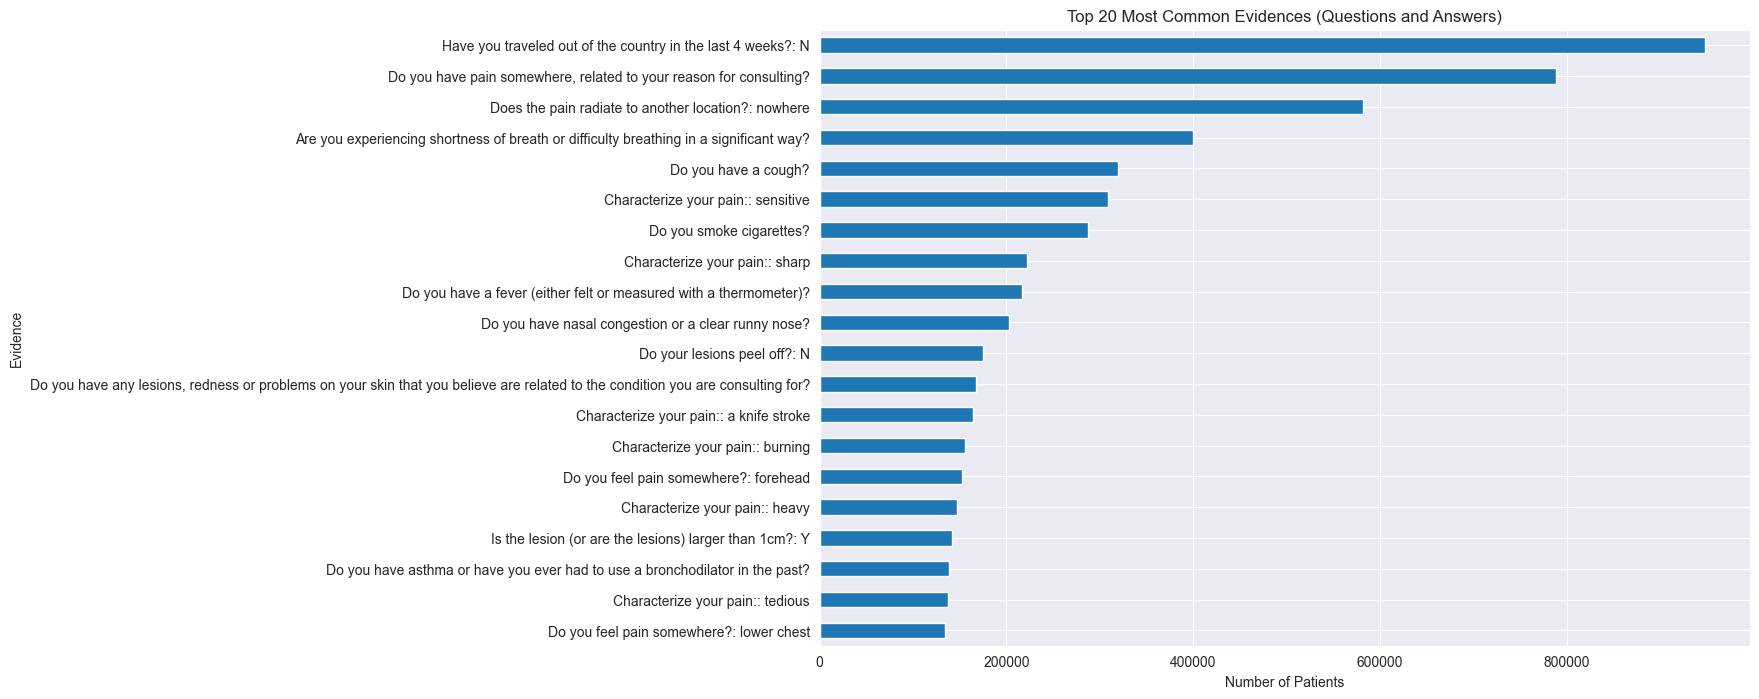

In [55]:
# Count occurrences of each evidence (both binary and categorical)
df_evidences_expanded_renamed = df_evidences_expanded.rename(columns=lambda x: evidence_mapping.get(x, x))
evidence_counts_renamed = df_evidences_expanded_renamed.sum().sort_values(ascending=False)

# Plot the top 20 most common evidences
plt.figure(figsize=(12, 8))
evidence_counts_renamed.head(20).plot(kind='barh')
plt.title('Top 20 Most Common Evidences (Questions and Answers)')
plt.xlabel('Number of Patients')
plt.ylabel('Evidence')
plt.gca().invert_yaxis()  # To show the most frequent evidence at the top
plt.show()

/Users/alex/opt/anaconda3/envs/CausaLM-clinical-notes/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alex/opt/anaconda3/envs/CausaLM-clinical-notes/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alex/opt/anaconda3/envs/CausaLM-clinical-notes/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


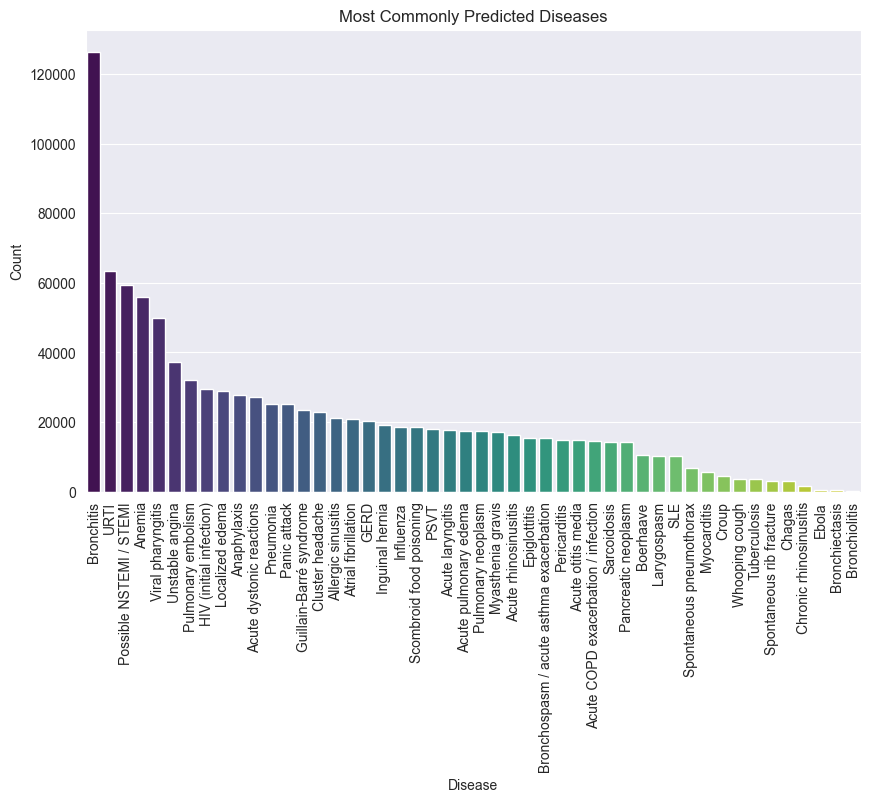

In [56]:
# Count the occurrences of each predicted pathology
common_diseases = train_df["AUTOMATIC_DIAGNOSIS_PREDICTION"].value_counts()

# Plot the most common diseases
plt.figure(figsize=(10, 6))
sns.barplot(x=common_diseases.index, y=common_diseases.values, palette='viridis')
plt.xticks(rotation=90)
plt.title('Most Commonly Predicted Diseases')
plt.xlabel('Disease')
plt.ylabel('Count')
plt.show()

## Model most common diseases in relation to the evidences with Logistic Regression

In [106]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Select features (evidences) and target (e.g., 'Bronchitis' presence)
X = df_evidences_expanded
y = (train_df['Bronchitis'] > 0).astype(int)  # Binary outcome (1 = predicted, 0 = not predicted)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# Get coefficients for the features
feature_importance = pd.Series(log_reg.coef_[0], index=X.columns)

# Plot the top 10 most influential evidences for 'Bronchitis'
top_features = feature_importance.abs().sort_values(ascending=False).head(10)
top_features.plot(kind='barh', title='Top Influential Evidences for Bronchitis')
plt.show()

KeyError: 'Bronchitis'